In [1]:
import pandas as pd
import os

data_path = '/home/jovyan/work/data'
data_path = 'D:\\analise-airbnb-rentabilite\data'
df = pd.read_csv(os.path.join(data_path, 'listings_process.csv'), sep=',')
df.head()

C:\Users\hugue\AppData\Local\Temp\ipykernel_23332\3606472673.py:6: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(data_path, 'listings_process.csv'), sep=',')


,id,room_type,price,availability_365,longitude,latitude,property_type,room_type.1,accommodates,bathrooms,bedrooms,beds,amenities,availability_30,availability_60,availability_90,availability_365.1,number_of_rooms,surface,price_per_m2
0,3109,Entire home/apt,113.0,297,2.31870,48.83191,Entire rental unit,Entire home/apt,2,1.0,1.0,1.0,"[Cooking basics, Luggage dropoff allowed, Iron...",6,20,35,297,3.0,30.0,113.00
1,5396,Entire home/apt,95.0,77,2.35835,48.85247,Entire rental unit,Entire home/apt,2,1.0,0.0,1.0,"[Hot water, Stove, Fire extinguisher, Oven, Cl...",3,24,54,77,2.0,20.0,142.50
2,7397,Entire home/apt,145.0,316,2.35315,48.85909,Entire rental unit,Entire home/apt,4,1.0,2.0,1.0,"[Host greets you, Heating, Refrigerator, Paid ...",6,30,49,316,4.0,40.0,108.75
3,11487,Entire home/apt,80.0,297,2.37139,48.86441,Entire rental unit,Entire home/apt,1,1.0,0.0,1.0,"[Hot water, Coffee maker, Cleaning products, W...",4,4,22,297,2.0,20.0,120.00
4,95915,Entire home/apt,160.0,21,2.38970,48.85484,Entire rental unit,Entire home/apt,2,1.0,1.0,1.0,"[Bathtub, Wifi, Cooking basics, Hot water, Por...",7,7,7,21,3.0,30.0,160.00


Uniques: 5312
Uniques: 5


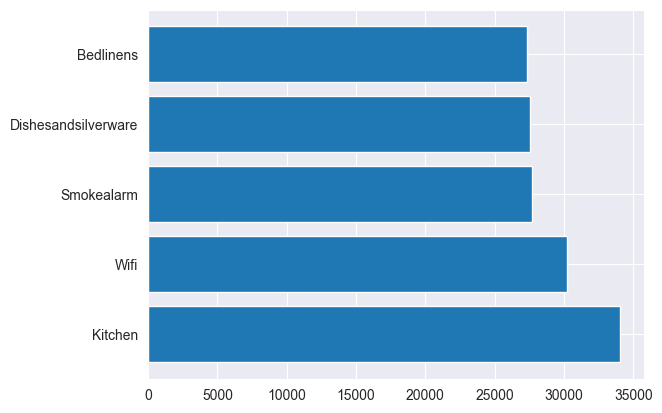

dict_keys(['Kitchen', 'Wifi', 'Smokealarm', 'Dishesandsilverware', 'Bedlinens'])


In [2]:
# Plot distribution of df['amenities'].unique()
import matplotlib.pyplot as plt

uniques = {}
for i in df['amenities']:
    for j in i.split(','):
        if j in uniques:
            uniques[j] += 1
        else:
            uniques[j] = 1
print(f"Uniques: {len(uniques)}")
# Keep only the top 5
uniques = {k.replace(" ", ''): v for k, v in sorted(uniques.items(), key=lambda item: item[1], reverse=True)[:5]}
print(f"Uniques: {len(uniques)}")
# plot with labels horizontaly
plt.barh(list(uniques.keys()), list(uniques.values()))
plt.show()
print(uniques.keys())

In [3]:
def preprocess_data(df):
    """
    'id', 'room_type', 'price', 'availability_365', 'longitude', 'latitude',
       'property_type', 'room_type.1', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'amenities', 'availability_30', 'availability_60',
       'availability_90', 'availability_365.1', 'number_of_rooms', 'surface',
       'price_per_m2'

    'Kitchen', 'Wifi', 'Smokealarm', 'Dishesandsilverware', 'Bedlinens', 'Refrigerator', 'Hairdryer', 'Hangers', 'Iron', 'Cookingbasics', 'Essentials', 'Microwave', 'Hotwaterkettle', 'Washer', 'Cleaningproducts', 'Wineglasses', 'Hotwater', 'Dedicatedworkspace', 'Shampoo', 'Heating'
    """
    print("Start preprocess data")
    print("Drop columns")
    df = df.copy()
    center_lat = df['latitude'].mean()
    center_lon = df['longitude'].mean()
    # Normalize latitude and longitude
    df['latitude'] = df['latitude'] - center_lat
    df['longitude'] = df['longitude'] - center_lon

    df['latitude'] = df['latitude'] / df['latitude'].max()
    df['longitude'] = df['longitude'] / df['longitude'].max()

    df['number_of_rooms'] = np.clip(df['number_of_rooms'], 0, 10)
    df['price'] = np.log1p(df['price'])
    df['price'] = np.clip(df['price'], 3.2, 7)
    # df['price'] = np.clip(df['price'], 10, 600)

    X = df.drop(
        ['id', 'room_type', 'room_type.1', 'property_type', 'availability_365.1', 'availability_30', 'availability_60',
         'availability_90', 'availability_365', 'price_per_m2', 'surface'],
        axis=1)
    # amenities: split by ',', to hot encode
    print("Process amenities")

    amenities_old = X['amenities']
    # create a raw df with uniques.keys() as columns
    amenities = pd.DataFrame()
    for k in uniques.keys():
        amenities[k] = amenities_old.apply(lambda x: 1 if k in x else 0)

    print("Concat amenities")
    X = pd.concat([X, amenities], axis=1)
    print("Drop amenities")
    X = X.drop(['amenities'], axis=1)

    return X

In [4]:
import time

def evaluate_model(train, test, model_name, model_display_name, model_class, model_params):
    t = time.time()
    X_train, y_train = train.drop(['price'], axis=1), train['price']
    X_test, y_test = test.drop(['price'], axis=1), test['price']
    print("Instantiate model")
    model = model_class(**model_params)
    print("Fit model")
    model.fit(X_train, y_train)
    print("Predict model")
    y_pred = model.predict(X_test)
    print("Drawing results statistics")
    print("Accuracy score")
    print(f'{model_display_name} Accuracy: {model.score(X_test, y_test):.2f}')
    print("Mean squared error")
    y_test = np.exp(y_test)
    y_pred = np.exp(y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print(f'{model_display_name} MSE: {mse:.2f}')
    mm = y_test - y_pred
    print(f"Mean: {mm.mean()}")
    print(f"Time: {time.time() - t}")
    # plot y-test vs y-pred
    plt.scatter(y_test, y_pred)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0, plt.xlim()[1]])
    plt.ylim([0, plt.ylim()[1]])
    _ = plt.plot([0, 1000], [0, 1000])
    plt.show()
    return {
        'model': model_name,
        'mse': mse,
        'model_params': model_params,
    }

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

df1 = preprocess_data(df)

Start preprocess data
Drop columns
Process amenities
Concat amenities
Drop amenities


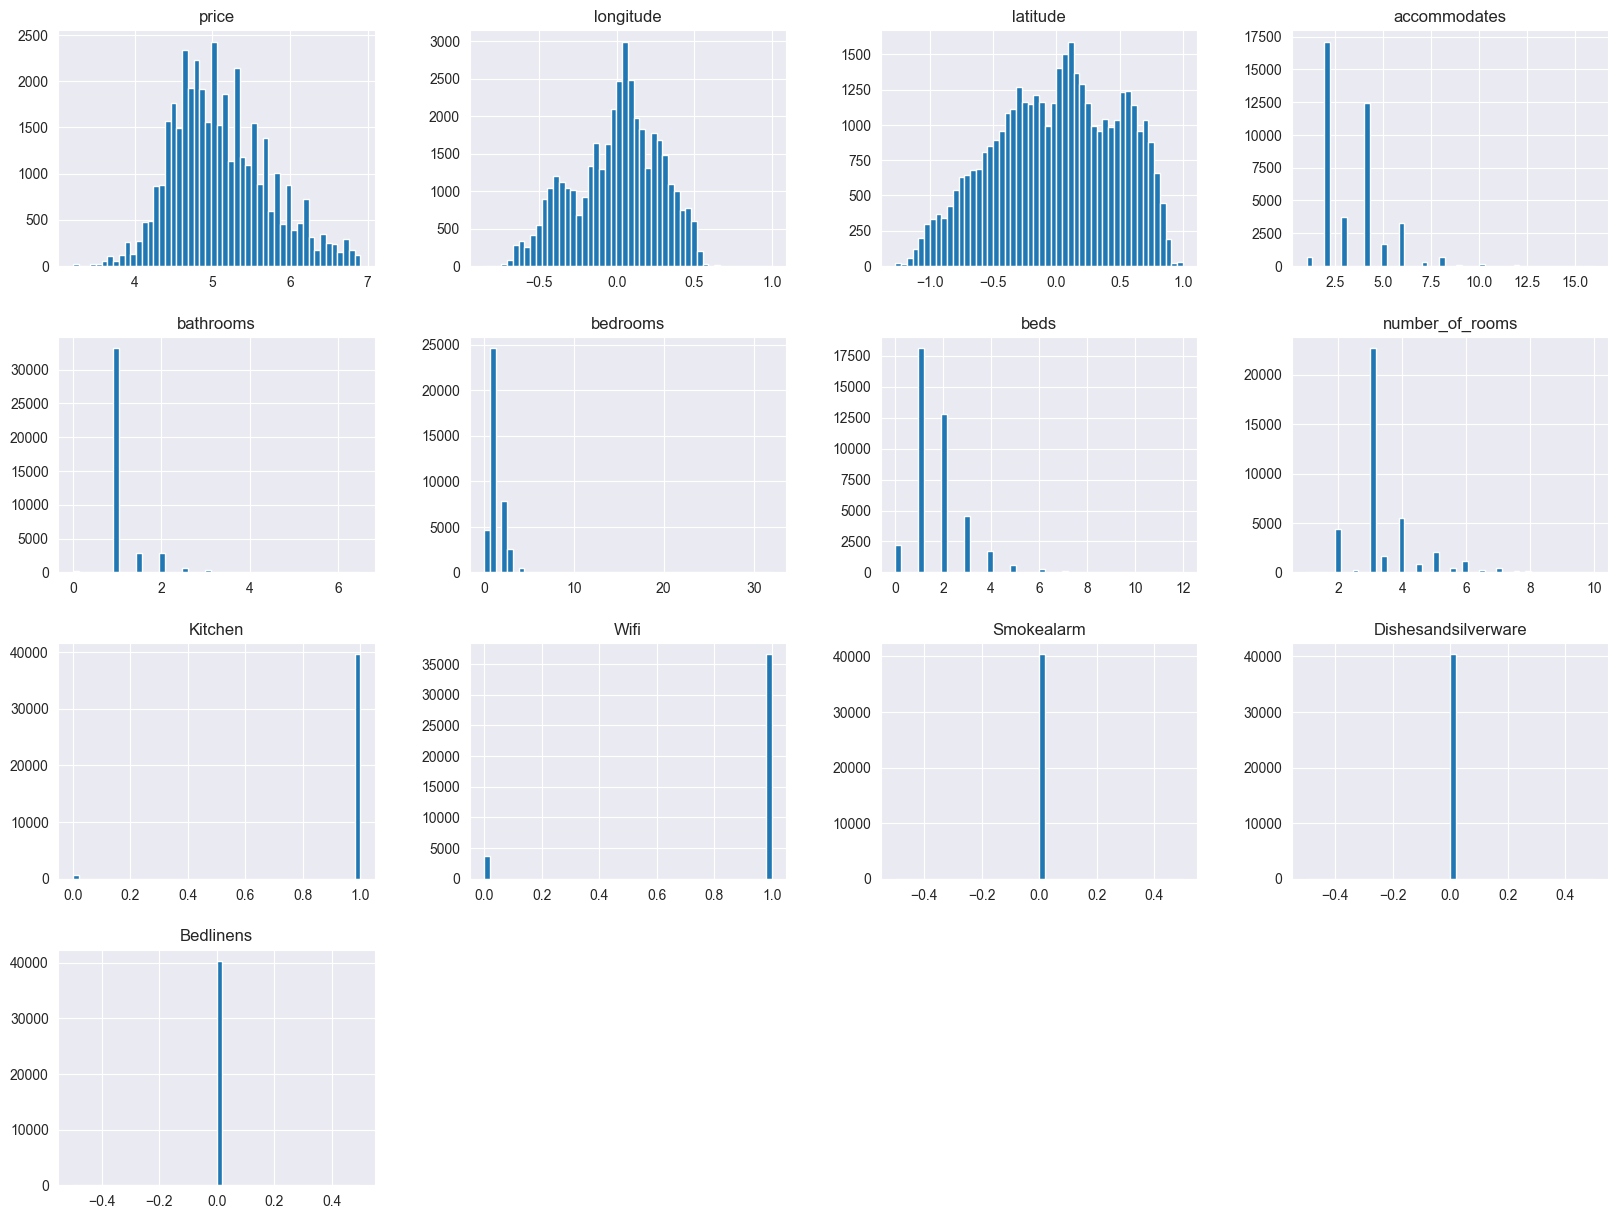

In [6]:
# Draw distribution of each column in df1
df1.hist(bins=50, figsize=(20, 15))
plt.show()

In [7]:
df1_train, df1_test = train_test_split(df1, test_size=0.2, random_state=42, shuffle=True)
print(f"Train shape: {df1_train.shape}")
print(f"Test shape: {df1_test.shape}")
print(df1_train.head())

Train shape: (32268, 13)
Test shape: (8068, 13)
          price  longitude  latitude  accommodates  bathrooms  bedrooms  beds  \
3142   5.707110   0.154305  0.509687             2        1.0       1.0   1.0   
18272  4.605170   0.069233  0.546024             2        1.0       1.0   1.0   
33924  4.615121  -0.104861  0.685598             2        1.0       1.0   1.0   
39513  5.888878  -0.007870  0.042189             4        1.0       2.0   2.0   
2306   5.135798   0.358585 -0.300498             4        1.0       1.0   2.0   

       number_of_rooms  Kitchen  Wifi  Smokealarm  Dishesandsilverware  \
3142               3.0        1     1           0                    0   
18272              3.0        1     1           0                    0   
33924              3.0        1     1           0                    0   
39513              4.0        1     1           0                    0   
2306               3.0        1     1           0                    0   

       Bedlinens  
3

In [8]:
print(df1_train)

          price  longitude  latitude  accommodates  bathrooms  bedrooms  beds  \
3142   5.707110   0.154305  0.509687             2        1.0       1.0   1.0   
18272  4.605170   0.069233  0.546024             2        1.0       1.0   1.0   
33924  4.615121  -0.104861  0.685598             2        1.0       1.0   1.0   
39513  5.888878  -0.007870  0.042189             4        1.0       2.0   2.0   
2306   5.135798   0.358585 -0.300498             4        1.0       1.0   2.0   
...         ...        ...       ...           ...        ...       ...   ...   
6265   4.532599  -0.277951 -0.664842             4        1.0       1.0   2.0   
11284  4.691348   0.262903  0.102788             3        1.0       1.0   2.0   
38158  4.700480   0.169292  0.156008             4        1.0       1.0   2.0   
860    5.198497   0.121379  0.262937             4        1.0       2.0   0.0   
15795  5.587249   0.011551 -0.070888             4        1.0       1.0   2.0   

       number_of_rooms  Kit

Instantiate model
Fit model
Predict model
Drawing results statistics
Accuracy score
SVR Accuracy: 0.35
Mean squared error
SVR MSE: 18768.46
Mean: 31.280924124132323
Time: 80.82896757125854


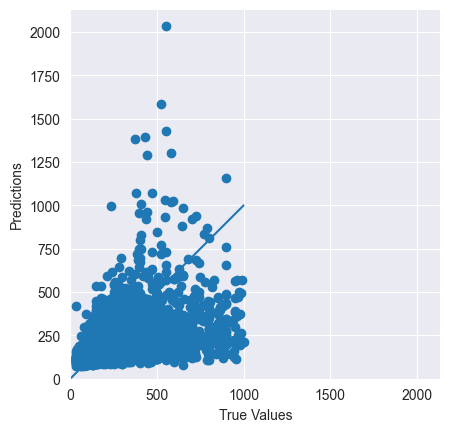

{'model': 'svr',
 'mse': np.float64(18768.45662487203),
 'model_params': {'kernel': 'linear', 'C': 1.0, 'epsilon': 0.01}}

In [11]:
from sklearn.svm import SVR

model = SVR

model_params = {
    'kernel': 'linear',
    'C': 1.0,
    'epsilon': 0.01
}

evaluate_model(df1_train, df1_test, 'svr', 'SVR', model, model_params)

In [10]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression

model_params = {
    'fit_intercept': True
}

evaluate_model(df1_train, df1_test, 'linear_regression', 'Linear Regression', model, model_params)

Instantiate model
Fit model


ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

Instantiate model
Fit model
Predict model
Drawing results statistics
Accuracy score
MLP Accuracy: 0.41
Mean squared error
MLP MSE: 16828.16
Mean: 39.31117007077662
Time: 3.880411148071289


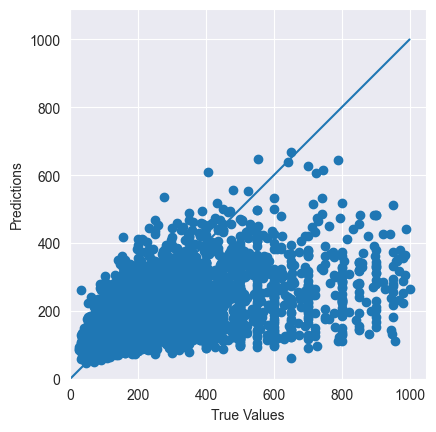

{'model': 'mlp',
 'mse': np.float64(16828.164537990015),
 'model_params': {'hidden_layer_sizes': (100,), 'activation': 'relu'}}

In [9]:
# Now using neural networks
from sklearn.neural_network import MLPRegressor

model = MLPRegressor

model_params = {
    'hidden_layer_sizes': (100,),
    'activation': 'relu',
}

evaluate_model(df1_train, df1_test, 'mlp', 'MLP', model, model_params)

In [ ]:
#Mutli-layer neural network
from sklearn.neural_network import MLPClassifier

model = MLPClassifier

model_params = {

    'hidden_layer_sizes': (100, 100, 50),
    'activation': 'relu',
}

evaluate_model(df1_train, df1_test, 'mlp', 'MLP', model, model_params)

In [ ]:
!pip install tensorflow

In [ ]:
from sklearn.metrics import mean_absolute_error

X_train, y_train = df1_train.drop(['price'], axis=1), df1_train['price']
X_test, y_test = df1_test.drop(['price'], axis=1), df1_test['price']

import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='tanh', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),  # Add dropout for regularization
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)  # Output layer for regression
])

# Compile the model with better loss and metrics
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[tf.keras.metrics.MeanAbsoluteError()])

# Add callbacks for better training control
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=1000,
    validation_data=(X_test, y_test),
    batch_size=64,
    verbose=2,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

In [ ]:
np.expm1(mse)

In [ ]:
for i in range(10):
    model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=2, batch_size=32)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# GridSearchCV avec Gradient Boosting
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}
model = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Évaluation
best_model = grid_search.best_estimator_
y_pred_log = best_model.predict(X_test)
y_pred = np.exp(y_pred_log)  # Re-transformer les prédictions

print("Meilleurs paramètres :", grid_search.best_params_)
print("MSE :", mean_squared_error(np.exp(y_test), y_pred))
